In [1]:
import yaml
import pandas as pd
from trainer import *

### Setting the config files
In this example, we will apply a Vanilla Neural Network to a setting of one store under a lost demand assumption.
Go to the respective config files to change the hyperparameters of the neural network or the setting

In [2]:
config_setting_file = 'config_files/settings/one_store_lost.yml'
config_hyperparams_file = 'config_files/policies_and_hyperparams/vanilla_one_store.yml'

In [3]:
with open(config_setting_file, 'r') as file:
    config_setting = yaml.safe_load(file)

with open(config_hyperparams_file, 'r') as file:
    config_hyperparams = yaml.safe_load(file)

setting_keys = 'seeds', 'test_seeds', 'problem_params', 'params_by_dataset', 'observation_params', 'store_params', 'warehouse_params', 'echelon_params', 'sample_data_params'
hyperparams_keys = 'trainer_params', 'optimizer_params', 'nn_params'
seeds, test_seeds, problem_params, params_by_dataset, observation_params, store_params, warehouse_params, echelon_params, sample_data_params = [
    config_setting[key] for key in setting_keys
    ]

trainer_params, optimizer_params, nn_params = [config_hyperparams[key] for key in hyperparams_keys]
observation_params = DefaultDict(lambda: None, observation_params)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dataset_creator = DatasetCreator()

# For realistic data, train, dev and test sets correspond to the same products, but over disjoint periods.
# We will therefore create one scenario, and then split the data into train, dev and test sets by 
# "copying" all non-period related information, and then splitting the period related information
if sample_data_params['split_by_period']:
    
    scenario = Scenario(
        periods=None,  # period info for each dataset is given in sample_data_params
        problem_params=problem_params, 
        store_params=store_params, 
        warehouse_params=warehouse_params, 
        echelon_params=echelon_params, 
        num_samples=params_by_dataset['train']['n_samples'],  # in this case, num_samples=number of products, which has to be the same across all datasets
        observation_params=observation_params, 
        seeds=seeds
        )
    
    train_dataset, dev_dataset, test_dataset = dataset_creator.create_datasets(
        scenario, 
        split=True, 
        by_period=True, 
        periods_for_split=[sample_data_params[k] for  k in ['train_periods', 'dev_periods', 'test_periods']],)

# For synthetic data, we will first create a scenario that we will divide into train and dev sets by sample index.
# Then, we will create a separate scenario for the test set, which will be exaclty the same as the previous scenario, 
# but with different seeds to generate demand traces, and with a longer time horizon.
# One can use this method of generating scenarios to train a model using some specific problem primitives, 
# and then test it on a different set of problem primitives, by simply creating a new scenario with the desired primitives.
else:
    scenario = Scenario(
        periods=params_by_dataset['train']['periods'], 
        problem_params=problem_params, 
        store_params=store_params, 
        warehouse_params=warehouse_params, 
        echelon_params=echelon_params, 
        num_samples=params_by_dataset['train']['n_samples'] + params_by_dataset['dev']['n_samples'], 
        observation_params=observation_params, 
        seeds=seeds
        )

    train_dataset, dev_dataset = dataset_creator.create_datasets(scenario, split=True, by_sample_indexes=True, sample_index_for_split=params_by_dataset['dev']['n_samples'])

    scenario = Scenario(
        params_by_dataset['test']['periods'], 
        problem_params, 
        store_params, 
        warehouse_params, 
        echelon_params, 
        params_by_dataset['test']['n_samples'], 
        observation_params, 
        test_seeds
        )

    test_dataset = dataset_creator.create_datasets(scenario, split=False)

train_loader = DataLoader(train_dataset, batch_size=params_by_dataset['train']['batch_size'], shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=params_by_dataset['dev']['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params_by_dataset['test']['batch_size'], shuffle=False)
data_loaders = {'train': train_loader, 'dev': dev_loader, 'test': test_loader}

neural_net_creator = NeuralNetworkCreator
model = neural_net_creator().create_neural_network(scenario, nn_params, device=device)

loss_function = PolicyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_params['learning_rate'])

simulator = Simulator(device=device)
trainer = Trainer(device=device)

# We will create a folder for each day of the year, and a subfolder for each model
# When executing with different problem primitives (i.e. instance), it might be useful to create an additional subfolder for each instance
trainer_params['base_dir'] = 'saved_models'
trainer_params['save_model_folders'] = [trainer.get_year_month_day(), nn_params['name']]

# We will simply name the model with the current time stamp
trainer_params['save_model_filename'] = trainer.get_time_stamp()

# Load previous model if load_model is set to True in the config file
if trainer_params['load_previous_model']:
    print(f'Loading model from {trainer_params["load_model_path"]}')
    model, optimizer = trainer.load_model(model, optimizer, trainer_params['load_model_path'])

/user/ma4177/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [18]:
trainer.train(
    trainer_params['epochs'], 
    loss_function, simulator, 
    model, 
    data_loaders, 
    optimizer, 
    problem_params, 
    observation_params, 
    params_by_dataset, 
    trainer_params)

epoch: 1
Average per-period train loss: 7.156120300292969
Average per-period dev loss: 7.167795944213867
Best per-period dev loss: 7.167795944213867
epoch: 2
Average per-period train loss: 7.164272308349609
Average per-period dev loss: 7.188082122802735
Best per-period dev loss: 7.167795944213867
epoch: 3
Average per-period train loss: 7.166550827026367
Average per-period dev loss: 7.166061210632324
Best per-period dev loss: 7.166061210632324
epoch: 4
Average per-period train loss: 7.151179695129395
Average per-period dev loss: 7.163067245483399
Best per-period dev loss: 7.163067245483399
epoch: 5
Average per-period train loss: 7.148781585693359
Average per-period dev loss: 7.162915992736816
Best per-period dev loss: 7.162915992736816
epoch: 6
Average per-period train loss: 7.151132583618164
Average per-period dev loss: 7.161979675292969
Best per-period dev loss: 7.161979675292969
epoch: 7
Average per-period train loss: 7.144277954101563
Average per-period dev loss: 7.152254104614258
B

KeyboardInterrupt: 

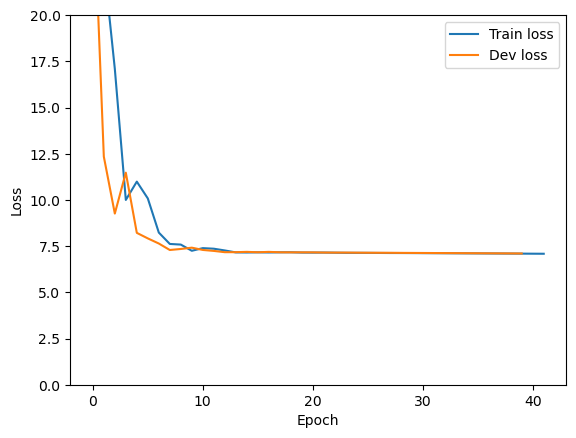

In [19]:
# plot the losses
ymin, ymax = 0, 20  # set the y-axis limit for the plot
trainer.plot_losses(ymin=ymin, ymax=ymax)

### Evaluate on test set

In [20]:
average_test_loss, average_test_loss_to_report = trainer.test(
    loss_function, 
    simulator, 
    model, 
    data_loaders, 
    optimizer, 
    problem_params, 
    observation_params, 
    params_by_dataset, 
    discrete_allocation=store_params['demand']['distribution'] == 'poisson'
    )

In [21]:
print(f'Average per-period test loss: {average_test_loss_to_report}')

Average per-period test loss: 7.147010040283203
